# Чтение и предобработка данных ионосферного зондирования

## Импорт библиотек

In [92]:
import numpy as np

# from parse import parse
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pylab as plt
import glob
import seaborn as sns

plt.rcParams["figure.figsize"] = [10, 5]

# Apply the default theme
sns.set_theme()
# sns.set_context("poster")

## Что и откуда читаем

In [93]:
dir = "test/NZ 062024" # Папка с данными
trace = "M"  # Префикс, означающий трассу
template_path = "template.xlsx" # файл-шаблон

In [94]:
# Функция для преобразования строки даты и времени в np.datetime64
def parse_datetime(date_str, time_str):
    dt_str = f"{date_str.decode('utf-8')} {time_str.decode('utf-8')}"
    return np.datetime64(datetime.strptime(dt_str, "%Y.%m.%d %H:%M:%S"))

In [95]:
# Чтение данных из файла
def load_file(filename):
    data = np.loadtxt(
        filename,
        usecols=(3, 5, 7),
        encoding="cp1251",
        dtype={"names": ("date", "time", "freq"), "formats": ("S10", "S10", "f")},
    )
    # Объединение даты и времени в np.datetime64
    datetime_array = np.array(
        [parse_datetime(row["date"], row["time"]) for row in data]
    )

    # Создаем DataFrame
    df = pd.DataFrame({"datetime": datetime_array, "freq": data["freq"]})
    return df

In [96]:
# Загружаем данные из нескольких файлов
file_names = []  # file_names = ["M20231015.txt", "M20231012.txt", "M20231011.txt"]
for fname in glob.iglob(dir+'/'+trace+"*.txt"):
    file_names.append(fname)
file_names.sort()

dataframes = [load_file(fname) for fname in file_names]

# Объединяем все DataFrame по столбцу 'datetime'
merged_df = pd.concat(dataframes, ignore_index=True)

merged_df["month_year_time"] = (
    merged_df["datetime"].dt.floor("5min").dt.strftime("%Y-%m %H:%M")
)
merged_df["day"] = merged_df["datetime"].dt.strftime("%d")


In [97]:
# Группируем с точностью до 5 минут и вычисляем статистику
# Год-месяц и время с точностью до 5 минут
result_df_u = (
    merged_df.groupby(pd.Grouper(key="month_year_time"))
    .agg(
        count=("freq", "size"),  # Количество измерений
        mean_freq=("freq", "mean"),  # Среднее значение
        std_freq=("freq", "std"),  # Стандартное отклонение
    )
    .reset_index()
)


result_df_u["time"] = pd.to_datetime(
    result_df_u["month_year_time"], format="%Y-%m %H:%M"
)
result_df_u["utime"] = pd.to_datetime(
    result_df_u["month_year_time"], format="%Y-%m %H:%M"
).dt.time

result_df = result_df_u.sort_values(by=["time"])


# Выводим результат
print(result_df)

    month_year_time  count  mean_freq  std_freq                time     utime
0     2024-06 00:00      7  21.114744  4.048784 2024-06-01 00:00:00  00:00:00
1     2024-06 00:05      7  21.369785  3.874489 2024-06-01 00:05:00  00:05:00
2     2024-06 00:10      7  21.655001  4.093157 2024-06-01 00:10:00  00:10:00
3     2024-06 00:15      7  21.799242  4.049944 2024-06-01 00:15:00  00:15:00
4     2024-06 00:20      7  21.475956  3.465612 2024-06-01 00:20:00  00:20:00
..              ...    ...        ...       ...                 ...       ...
283   2024-06 23:35      7  25.195200  3.529568 2024-06-01 23:35:00  23:35:00
284   2024-06 23:40      7  25.146343  3.672734 2024-06-01 23:40:00  23:40:00
285   2024-06 23:45      7  25.035444  3.590143 2024-06-01 23:45:00  23:45:00
286   2024-06 23:50      7  24.968313  3.527920 2024-06-01 23:50:00  23:50:00
287   2024-06 23:55      7  25.054686  3.600265 2024-06-01 23:55:00  23:55:00

[288 rows x 6 columns]


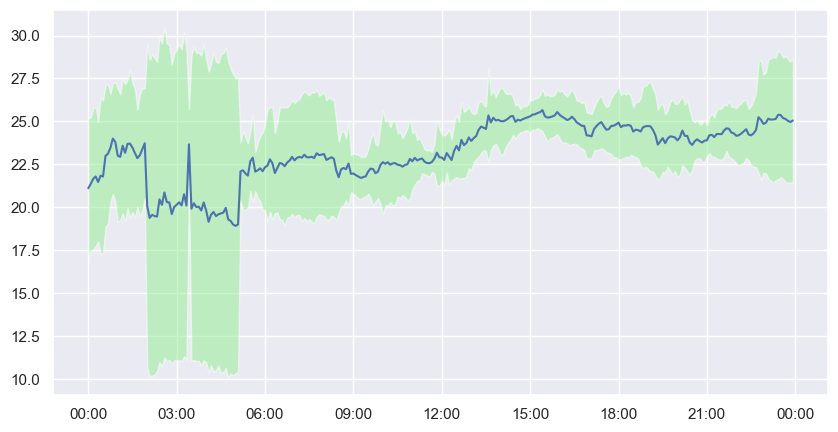

In [100]:
fig, ax = plt.subplots()

ax.plot(result_df["time"], result_df["mean_freq"])
ax.fill_between(
    result_df["time"],
    result_df["mean_freq"] - result_df["std_freq"],
    result_df["mean_freq"] + result_df["std_freq"],
    facecolor="lightgreen",
    alpha=0.5,
    label="1 sigma range",
)
# plt.xticks(rotation=20)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.savefig(dir+'/'+trace+".png", dpi=150, transparent=None)
plt.savefig(dir+'/'+trace+".pdf")
plt.savefig(dir+'/'+trace+".svg")
plt.show()

In [99]:
from openpyxl import load_workbook

xls_cols = ["month_year_time", "count", "mean_freq", "std_freq"]
sheet_name = "Sheet1"


# Загрузка шаблона
wb = load_workbook(template_path)
ws = wb.active

# Обновление данных в шаблоне
for row in result_df[xls_cols].itertuples(index=False):
    ws.append(row)

# Сохранение обновленного файла
output_path = dir+'/'+trace+".xlsx"
wb.save(output_path)